In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
from datetime import datetime, timedelta

In [26]:
import pandas as pd
import pmdarima as pm
from sklearn.linear_model import LinearRegression

def load_data(file_path):
    '''loads the series dataset'''
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['date'])
    return data

def stationarize_data_multiplicative(df, n_periods=365):
    '''decompose and stationarize the series using multiplicative method, accepts dataframe and n_periods for decomposistion
    produces stationarize dataframe and it's components'''
    dataframe = df.set_index('date').asfreq('D')
    result_decomposition = seasonal_decompose(dataframe['sales'], model='multiplicative', period=n_periods, extrapolate_trend='freq')
    y_diff = (dataframe['sales']/result_decomposition.seasonal/result_decomposition.trend).dropna()
    return y_diff, result_decomposition

def stationarize_data_additive(df, n_periods=365):
    '''decompose and stationarize the series using additive method if trend and seasonality values are zero, accepts dataframe and n_periods for decomposistion
    produces stationarize dataframe and it's components.'''
    dataframe = df.set_index('date').asfreq('D')
    result_decomposition = seasonal_decompose(dataframe['sales'], model='additive', period=n_periods, extrapolate_trend='freq')
    y_diff = (dataframe['sales']-result_decomposition.seasonal-result_decomposition.trend).dropna()
    return y_diff, result_decomposition
    
def auto_arima(dataframe, futures=365):
    '''making an auto arima model with the stationarized data, the futures are the number periods that the user wish to predict
    standard is one year. For multiplicative seasonal decomposed time series'''
    smodel = pm.auto_arima(dataframe, stationary=True, method='lbfgs', seasonal=True, m=12,
                       start_p=0, max_p=5, max_d=0, start_q=0, max_q=3,
                       start_P=0, max_P=2, max_D=0, start_Q=0, max_Q=3, 
                       trace=True, error_action='warn', suppress_warnings=True, n_fits=3, test='adf', random=True, maxiter=3)
    y_forec, conf_int  = smodel.predict(futures,return_conf_int=True,alpha=0.05)
    forecast = pd.DataFrame(y_forec, columns=['forecast'])
    conf_int = pd.DataFrame(conf_int, index=forecast.index, columns=['low','high'])
    return forecast, conf_int, smodel.aic()

def auto_arima_add(dataframe, futures=365):
    '''making an auto arima model with the stationarized data, the futures are the number periods that the user wish to predict
    standard is one year. Reduced fitting parameters for additive seasonal decomposed time series'''
    smodel = pm.auto_arima(dataframe, stationary=True, method='lbfgs', seasonal=True, m=12,
                       start_p=0, max_p=3, max_d=0, start_q=0, max_q=3,
                       start_P=0, max_P=2, max_D=0, start_Q=0, max_Q=3, 
                       trace=True, error_action='warn', suppress_warnings=True, n_fits=1, test='adf', random=True, maxiter=1)
    y_forec, conf_int  = smodel.predict(futures,return_conf_int=True,alpha=0.05)
    forecast = pd.DataFrame(y_forec, columns=['forecast'])
    conf_int = pd.DataFrame(conf_int, index=forecast.index, columns=['low','high'])
    return forecast, conf_int, smodel.aic()

def recompose_forecast_multiplicative(df_diff, df_forecast, confindence_interval, decomposition):
    '''Forecast the trend and seasonal components using Holt-Winters method, then Extrapolate the trend and seasonal components into the future
    . MULTIPLICATIVE METHOD'''
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    #holt winters method
    hw_trend = ExponentialSmoothing(trend, seasonal_periods=365, trend='mul', seasonal='mul').fit()
    hw_seasonal = ExponentialSmoothing(seasonal, seasonal_periods=365, trend=None, seasonal='mul').fit()
    #extrapolate into the future
    future_dates = pd.date_range(start=df_diff.index[-1]+timedelta(days=1), periods=365, freq='D')
    future_trend = hw_trend.predict(start=future_dates[0], end=future_dates[-1])
    future_seasonal = hw_seasonal.predict(start=future_dates[0], end=future_dates[-1])
    df_forecast['composed_forecast']=df_forecast['forecast']*future_trend*future_seasonal
    confindence_interval['low_composed']=confindence_interval['low']*future_trend*future_seasonal
    confindence_interval['high_composed']=confindence_interval['high']*future_trend*future_seasonal
    return df_forecast, confindence_interval

def recompose_forecast_additive(df_diff, df_forecast, confindence_interval, decomposition):
    '''Forecast the trend and seasonal components using Holt-Winters method, then Extrapolate the trend and seasonal components into the future
    . ADDITIVE METHOD'''
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    #holt winters method
    hw_trend = ExponentialSmoothing(trend, seasonal_periods=365, trend='add', seasonal=None).fit()
    hw_seasonal = ExponentialSmoothing(seasonal, seasonal_periods=365, trend=None, seasonal='add').fit()
    #extrapolate into the future
    future_dates = pd.date_range(start=df_diff.index[-1]+timedelta(days=1), periods=365, freq='D')
    future_trend = hw_trend.predict(start=future_dates[0], end=future_dates[-1])
    future_seasonal = hw_seasonal.predict(start=future_dates[0], end=future_dates[-1])
    df_forecast['composed_forecast']=df_forecast['forecast']+future_trend+future_seasonal
    confindence_interval['low_composed']=confindence_interval['low']+future_trend+future_seasonal
    confindence_interval['high_composed']=confindence_interval['high']+future_trend+future_seasonal
    return df_forecast, confindence_interval
    
def loop_through_arima(file_path):
    # load the data
    forecast_df = pd.DataFrame(columns=['date', 'store', 'item', 'forecast'])
    aic_df = pd.DataFrame(columns=['store', 'item', 'aic'])
    conf_int_df = pd.DataFrame(columns=['date', 'store', 'item', 'low', 'high'])
    dataframe = load_data(file_path)

    # loop over the store and item categories
    for store in dataframe['store'].unique():
        for item in dataframe['item'].unique():
            
            print(f'processing number {store} & {item}, starting multiplicative method')

            # extract data for the current store and item combination
            data = dataframe[(dataframe['store'] == store) & (dataframe['item'] == item)]
            
            try:  
                # stationarize the data
                y_diff, decomposition = stationarize_data_multiplicative(data, n_periods=365)

                # fit an ARIMA model to the stationarized data
                forecast, conf_int, aic = auto_arima(y_diff)

                # recompose the forecast to obtain predictions for the original data
                forecast, conf_int = recompose_forecast_multiplicative(y_diff, forecast, conf_int, decomposition)
            except ValueError:
                
                print('multiplicative method failed, additive method will be used')
                # stationarize the data
                y_diff, decomposition = stationarize_data_additive(data, n_periods=365)

                # fit an ARIMA model to the stationarized data
                forecast, conf_int, aic = auto_arima_add(y_diff)

                # recompose the forecast to obtain predictions for the original data
                forecast, conf_int = recompose_forecast_additive(y_diff, forecast, conf_int, decomposition)

            # add the forecast and AIC score to the respective dataframes
            conf_int_df = conf_int_df.append(pd.DataFrame({'date': forecast.index, 'store': store, 'item': item, 'low': conf_int['low_composed'].values, 'high': conf_int['high_composed'].values}))
            forecast_df = forecast_df.append(pd.DataFrame({'date': forecast.index, 'store': store, 'item': item, 'forecast': forecast['composed_forecast'].values}))
            aic_df = aic_df.append(pd.DataFrame({'store': [store], 'item': [item], 'aic': [aic]}))
            print(f"aic score for {store} & {item}: {aic}")
    
    return forecast_df, aic_df, conf_int_df

    
    
    

In [27]:
forecast_df, aic_df, conf_int_df = loop_through_arima('train.csv')

processing number 1 & 1, starting multiplicative method
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-24.553, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-39.726, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5290.899, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-23.354, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2989.609, Time=0.79 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-68.308, Time=1.28 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2806.193, Time=2.90 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=-61.164, Time=3.54 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=3177.901, Time=6.06 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-66.598, Time=1.11 sec
 ARIMA(1,0,1)(0,0,2)[12] intercept   : AIC=-65.176, Time=1.94 sec
 ARIMA(0,0,2)(0,0,2)[12] intercept   : AIC=-72.894, Time=2.26 sec
 ARIMA(0,0,2)(0,0,1)[12] intercept   : AIC=

/home/itcwork66/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/home/itcwork66/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/tmp/ipykernel_1184/888224976.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conf_int_df = conf_int_df.append(pd.DataFrame({'date': forecast.index, 'store': store, 'item': item, 'low': conf_int['low_composed'].values, 'high': conf_int['high_composed'].values}))
/tmp/ipykernel_1184/888224976.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append(pd.DataFrame({'date': forecast.ind

aic score for 1 & 1: -72.89386095604351
processing number 1 & 2, starting multiplicative method
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1181.900, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1175.932, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5252.730, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-1180.998, Time=0.40 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-1182.048, Time=0.44 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=-1178.342, Time=0.51 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=-1183.816, Time=0.15 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(2,0,0)(0,0,1)[12] intercept   : AIC=-1179.292, Time=0.68 sec
 ARIMA(2

/home/itcwork66/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/tmp/ipykernel_1184/888224976.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  conf_int_df = conf_int_df.append(pd.DataFrame({'date': forecast.index, 'store': store, 'item': item, 'low': conf_int['low_composed'].values, 'high': conf_int['high_composed'].values}))
/tmp/ipykernel_1184/888224976.py:124: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecast_df = forecast_df.append(pd.DataFrame({'date': forecast.index, 'store': store, 'item': item, 'forecast': forecast['composed_forecast'].values}))
/tmp/ipykernel_1184/888224976.py:125: FutureWarning: The frame.append method is deprecated and will be r

aic score for 1 & 2: -1280.4404097207405
processing number 1 & 3, starting multiplicative method
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-754.793, Time=0.14 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-760.826, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=5257.741, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-758.859, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=2556.176, Time=0.66 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=-815.872, Time=1.53 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=2106.822, Time=2.79 sec
 ARIMA(0,0,1)(0,0,3)[12] intercept   : AIC=-811.264, Time=3.81 sec
 ARIMA(0,0,1)(1,0,3)[12] intercept   : AIC=inf, Time=4.43 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=-817.825, Time=1.18 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-765.381, Time=0.49 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=2936.713, Time=1.93 sec

KeyboardInterrupt: 

In [ ]:
test_df = pd.read_csv('test.csv')
submission_df = pd.merge(test_df, forecast_df, how='inner', on=['date', 'store', 'item'])[['id', 'forecast']]
submission_df.rename(columns={'forecast':'sales'}, inplace=True)
submission_df.sales = submission_df.sales.astype('int32')
submission_df.set_index(['id'], inplace=True)
submission_df.to_csv('submission_arima_basic.csv')

In [19]:
data.set_index('date', inplace=True)

In [20]:
import matplotlib.pyplot as plt
#visualize purposes

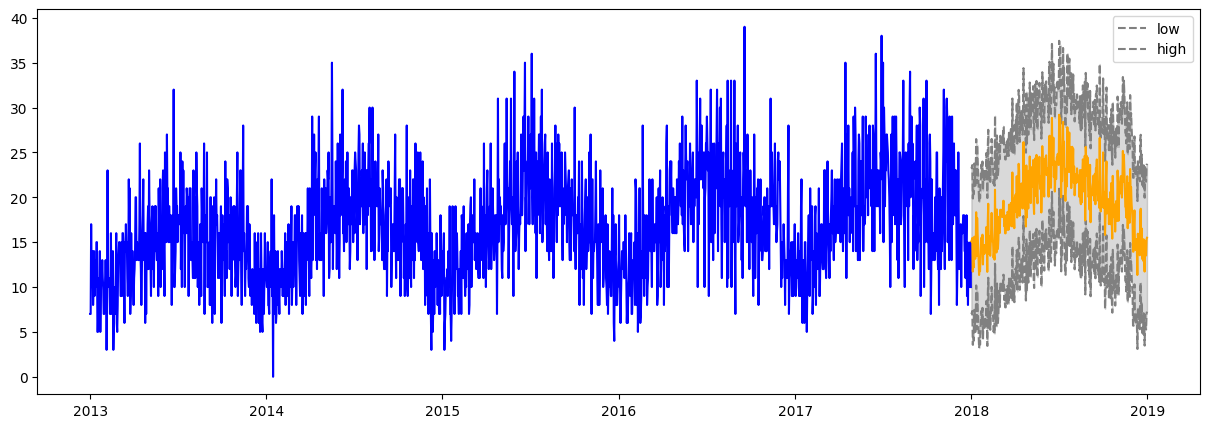

In [21]:
plt.figure(figsize=(15,5))


plt.plot(conf_int['low_composed'], label='low', c='grey', ls='--')
plt.plot(conf_int['high_composed'], label='high', c='grey', ls='--')
plt.plot(data['sales'], c='blue')
plt.plot(forecast['composed_forecast'], c='orange')
plt.legend()
plt.fill_between(forecast.index, conf_int['low_composed'], conf_int['high_composed'], color='k', alpha=.15);